РЕГРЕССИЯ ДЛЯ log_SI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

sns.set_style("whitegrid")

In [2]:
print("Загрузка обработанного датафрейма")
processed_excel_file = 'processed_compounds_data.xlsx'
df = pd.read_excel(processed_excel_file)

Загрузка обработанного датафрейма


In [3]:
print("Определение признаков и целевых переменных для каждой задачи")
feature_columns = [
    col for col in df.columns
    if col not in ['IC50, mM', 'CC50, mM', 'SI', 'log_IC50', 'log_CC50', 'log_SI']
    and df[col].dtype in ['float64', 'int64']
]

if not feature_columns:
    print("Ошибка: Не удалось найти числовые признаки для моделирования. Проверьте ваш DataFrame.")
    exit()

print(f"Общее количество доступных признаков-дескрипторов: {len(feature_columns)}")

Определение признаков и целевых переменных для каждой задачи
Общее количество доступных признаков-дескрипторов: 163


In [4]:
#  Функция для оценки модели и вывода результатов
def evaluate_model(model, X_test, y_test, target_name, model_name):
    """Оценивает модель и выводит метрики, а также график прогнозов."""
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Результаты для {model_name} (Прогнозирование {target_name})")
    print(f"Среднеквадратичная ошибка (MSE): {mse:.4f}")
    print(f"Корень из среднеквадратичной ошибки (RMSE): {rmse:.4f}")
    print(f"Средняя абсолютная ошибка (MAE): {mae:.4f}")
    print(f"Коэффициент детерминации (R^2): {r2:.4f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'Прогнозы {model_name} vs Фактические значения ({target_name})')
    plt.xlabel(f'Фактические значения {target_name}')
    plt.ylabel(f'Прогнозируемые значения {target_name}')
    plt.grid(True)
    plt.show()

    return {'model_name': model_name, 'target': target_name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [5]:
results_summary = [] # Для сбора результатов всех моделей

In [6]:
# Создаем набор признаков, исключая IC50, CC50 и их логарифмированные версии
X_si_features = [col for col in feature_columns if 'IC50' not in col and 'CC50' not in col]
y_si = df['log_SI']
X_si = df[X_si_features]

# Разделение на обучающую и тестовую выборки
X_train_si, X_test_si, y_train_si, y_test_si = train_test_split(X_si, y_si, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler_si = StandardScaler()
X_train_si_scaled = scaler_si.fit_transform(X_train_si)
X_test_si_scaled = scaler_si.transform(X_test_si)

Обучение Linear Regression для log_SI
Результаты для Linear Regression (Прогнозирование log_SI)
Среднеквадратичная ошибка (MSE): 0.6184
Корень из среднеквадратичной ошибки (RMSE): 0.7864
Средняя абсолютная ошибка (MAE): 0.5899
Коэффициент детерминации (R^2): -0.0136


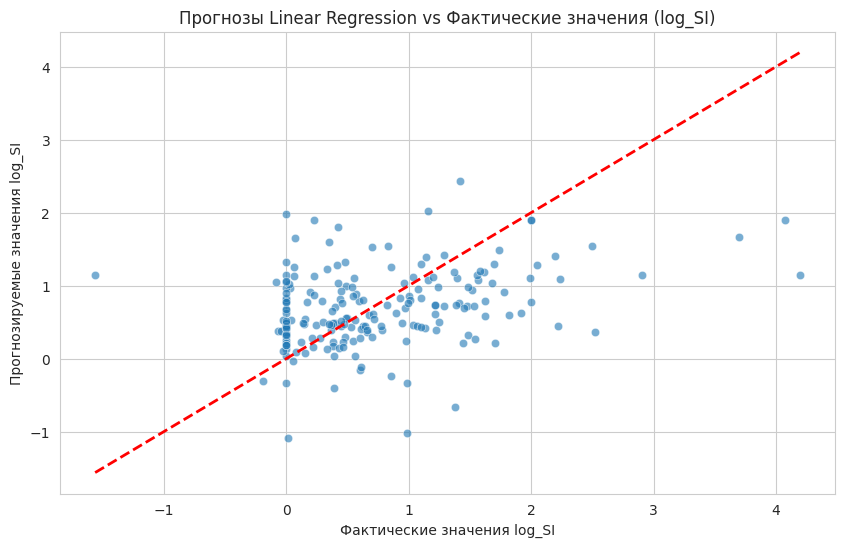

In [7]:
# 1. Линейная регрессия
print("Обучение Linear Regression для log_SI")
lr_si = LinearRegression()
lr_si.fit(X_train_si_scaled, y_train_si)
results_summary.append(evaluate_model(lr_si, X_test_si_scaled, y_test_si, 'log_SI', 'Linear Regression'))

Настройка гиперпараметров для Random Forest Regressor (log_SI)
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучшие гиперпараметры для Random Forest (log_SI): {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}
Результаты для Random Forest (Прогнозирование log_SI)
Среднеквадратичная ошибка (MSE): 0.4422
Корень из среднеквадратичной ошибки (RMSE): 0.6650
Средняя абсолютная ошибка (MAE): 0.4911
Коэффициент детерминации (R^2): 0.2752


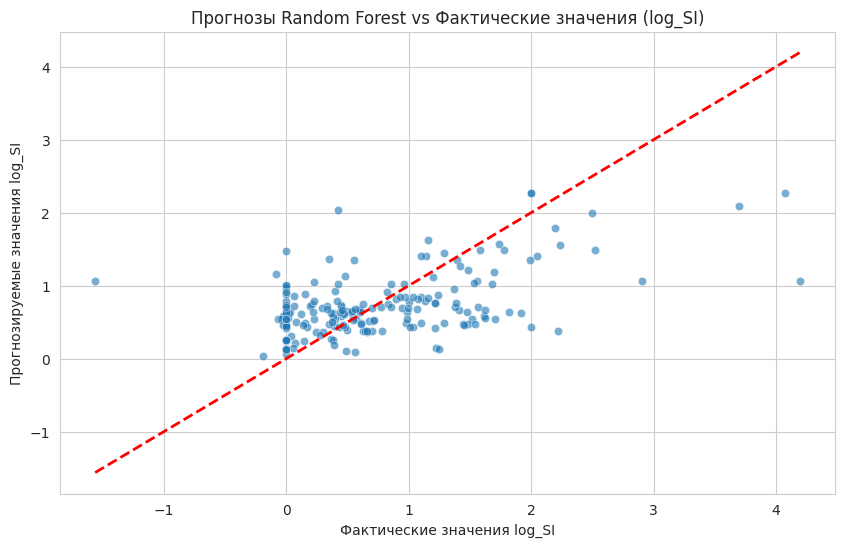

In [8]:
# 2. Random Forest Regressor
print("Настройка гиперпараметров для Random Forest Regressor (log_SI)")
param_grid_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_leaf': [1, 2, 4]}
grid_search_rf_si = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_rf_si.fit(X_train_si, y_train_si)
best_rf_si = grid_search_rf_si.best_estimator_
print(f"Лучшие гиперпараметры для Random Forest (log_SI): {grid_search_rf_si.best_params_}")
results_summary.append(evaluate_model(best_rf_si, X_test_si, y_test_si, 'log_SI', 'Random Forest'))

Настройка гиперпараметров для Gradient Boosting Regressor (log_SI)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие гиперпараметры для Gradient Boosting (log_SI): {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Результаты для Gradient Boosting (Прогнозирование log_SI)
Среднеквадратичная ошибка (MSE): 0.4517
Корень из среднеквадратичной ошибки (RMSE): 0.6721
Средняя абсолютная ошибка (MAE): 0.4955
Коэффициент детерминации (R^2): 0.2596


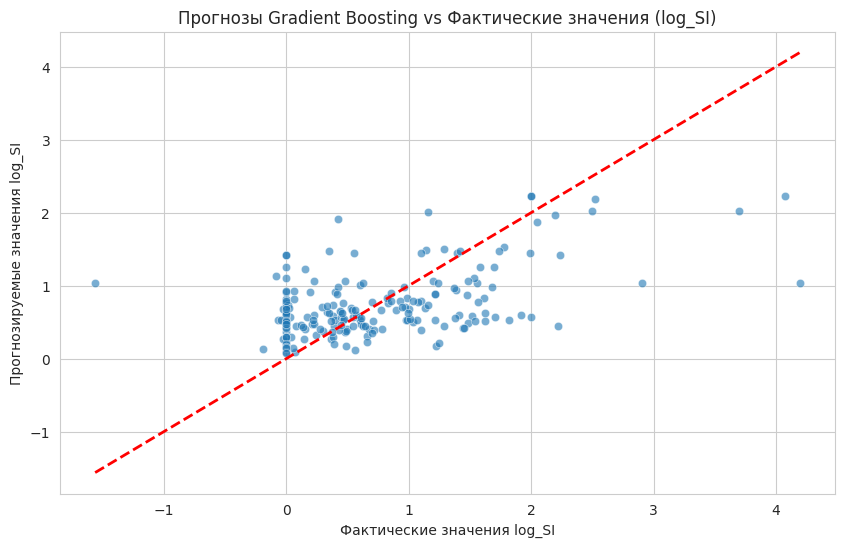

In [9]:
# 3. Gradient Boosting Regressor
print("Настройка гиперпараметров для Gradient Boosting Regressor (log_SI)")
param_grid_gb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]}
grid_search_gb_si = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_gb_si.fit(X_train_si, y_train_si)
best_gb_si = grid_search_gb_si.best_estimator_
print(f"Лучшие гиперпараметры для Gradient Boosting (log_SI): {grid_search_gb_si.best_params_}")
results_summary.append(evaluate_model(best_gb_si, X_test_si, y_test_si, 'log_SI', 'Gradient Boosting'))

Настройка гиперпараметров для XGBoost Regressor (log_SI)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие гиперпараметры для XGBoost (log_SI): {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Результаты для XGBoost (Прогнозирование log_SI)
Среднеквадратичная ошибка (MSE): 0.4654
Корень из среднеквадратичной ошибки (RMSE): 0.6822
Средняя абсолютная ошибка (MAE): 0.5184
Коэффициент детерминации (R^2): 0.2371


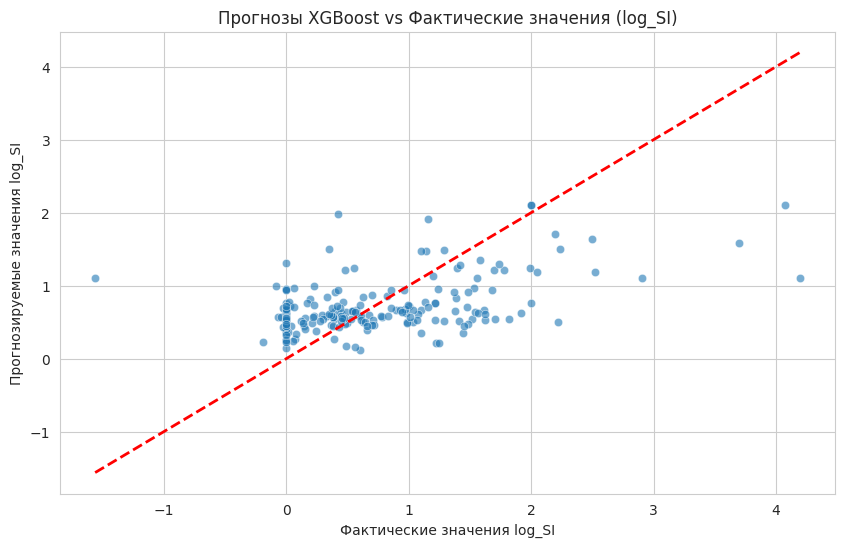

In [10]:
# 4. XGBoost Regressor
print("Настройка гиперпараметров для XGBoost Regressor (log_SI)")
param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]}
grid_search_xgb_si = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_xgb_si.fit(X_train_si, y_train_si)
best_xgb_si = grid_search_xgb_si.best_estimator_
print(f"Лучшие гиперпараметры для XGBoost (log_SI): {grid_search_xgb_si.best_params_}")
results_summary.append(evaluate_model(best_xgb_si, X_test_si, y_test_si, 'log_SI', 'XGBoost'))

In [11]:
# таблица результатов
print("Таблица результатов моделей для log_SI")
results_df = pd.DataFrame(results_summary)
print(results_df.sort_values(by=['target', 'R2'], ascending=[True, False]))

Таблица результатов моделей для log_SI
          model_name  target       MSE      RMSE       MAE        R2
1      Random Forest  log_SI  0.442210  0.664989  0.491139  0.275185
2  Gradient Boosting  log_SI  0.451731  0.672110  0.495540  0.259579
3            XGBoost  log_SI  0.465427  0.682222  0.518437  0.237131
0  Linear Regression  log_SI  0.618374  0.786368  0.589872 -0.013562
